<a href="https://colab.research.google.com/github/ElloRabyndra/skin-type-classification/blob/main/skin_type_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Library
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools

In [ ]:
# Konfigurasi Dataset
DATA_DIR = 'dataset'
CLASS_LABELS = ['Cool', 'Neutral', 'Warm']
IMAGE_SIZE = (128, 128) # Ukuran seragam

def load_and_preprocess_color_data(data_dir, class_labels, img_size):
    """Memuat dan melakukan preprocessing citra warna (RGB)."""
    all_images = []
    all_labels = []

    # Tinggi x Lebar x Kanal Warna
    target_feature_size = img_size[0] * img_size[1] * 3

    for label_idx, label_name in enumerate(class_labels):
        folder_path = os.path.join(data_dir, label_name)

        if not os.path.isdir(folder_path):
            print(f"Peringatan: Folder {folder_path} tidak ditemukan. Melewatkan kelas ini.")
            continue

        print(f"Memuat citra WARNA (RGB) dari kelas: {label_name}...")

        for filename in os.listdir(folder_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(folder_path, filename)

                # Membaca gambar dalam format WARNA
                img = cv2.imread(img_path)

                if img is None:
                    continue

                # 1. Resize gambar ke ukuran seragam (128x128)
                img_resized = cv2.resize(img, img_size)

                # 2. Konversi BGR ke RGB (Memastikan urutan kanal warna yang konsisten)
                img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

                # 3. Mengubah matriks 3D (128x128x3) menjadi vektor 1D
                feature_vector = img_rgb.flatten()

                all_images.append(feature_vector)
                all_labels.append(label_idx)

    # Mengubah list menjadi array NumPy
    X_raw_color = np.array(all_images, dtype=np.float32)
    y = np.array(all_labels)

    # Output Statistik
    print(f"\nBentuk Data Citra (Raw Color Features): {X_raw_color.shape}")
    print(f"Jumlah Total Sampel: {len(X_raw_color)}")

    return X_raw_color, y

# Jalankan fungsi pemuatan data baru
X_raw_color, y = load_and_preprocess_color_data(DATA_DIR, CLASS_LABELS, IMAGE_SIZE)

Memuat citra WARNA (RGB) dari kelas: Cool...
Memuat citra WARNA (RGB) dari kelas: Neutral...
Memuat citra WARNA (RGB) dari kelas: Warm...

Bentuk Data Citra (Raw Color Features): (143, 49152)
Jumlah Total Sampel: 143


--- Visualisasi Dataset Awal dan Statistik ---


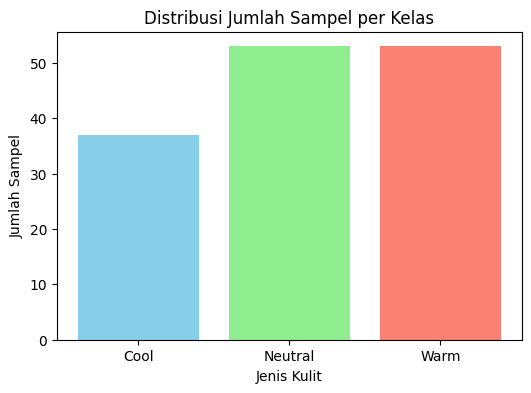

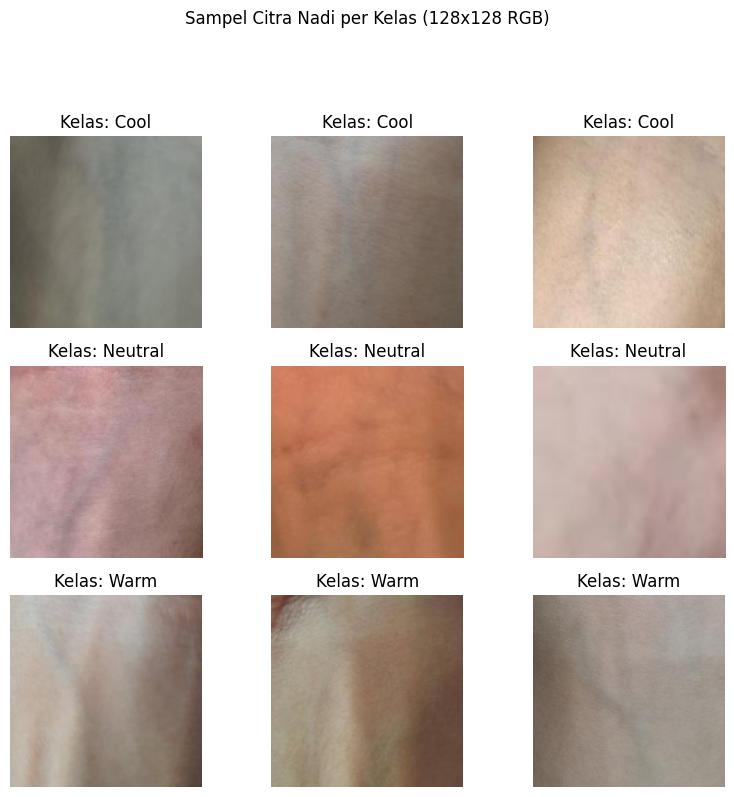

In [ ]:
# --- VISUALISASI DATASET AWAL ---
print("--- Visualisasi Dataset Awal dan Statistik ---")

# A. Statistik Dataset (Distribusi Kelas)
class_counts = np.bincount(y)
plt.figure(figsize=(6, 4))
plt.bar(CLASS_LABELS, class_counts, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Distribusi Jumlah Sampel per Kelas')
plt.xlabel('Jenis Kulit')
plt.ylabel('Jumlah Sampel')
plt.show()


# B. Tampilkan Sampel Citra Warna (3 sampel/kelas)
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('Sampel Citra Nadi per Kelas (128x128 RGB)', y=1.02)

# Normalisasi data mentah untuk tampilan (nilai piksel 0-1)
X_viz = X_raw_color / 255.0

for i, label_name in enumerate(CLASS_LABELS):
    # Cari indeks sampel untuk kelas ini
    indices = np.where(y == i)[0]

    # Ambil 3 sampel acak
    sample_indices = np.random.choice(indices, 3, replace=False)

    for j, idx in enumerate(sample_indices):
        # Ambil vektor fitur, reshape kembali ke matriks 3D (128x128x3)
        img_3d = X_viz[idx].reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

        ax = axes[i, j]
        ax.imshow(img_3d)
        ax.set_title(f'Kelas: {label_name}')
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
print("\n")
plt.show()

In [ ]:
# Normalisasi Data (rentang 0-1)
X_normalized_color = X_raw_color / 255.0

# Pembagian Data Latih (90%) dan Data Uji (15%)
X_train_color, X_test_color, y_train, y_test = train_test_split(
    X_normalized_color, y, test_size=0.1, random_state=42, stratify=y
)

print(f"Bentuk Data Latih (Color Normalized): {X_train_color.shape}")
print(f"Bentuk Data Uji (Color Normalized): {X_test_color.shape}")

Bentuk Data Latih (Color Normalized): (128, 49152)
Bentuk Data Uji (Color Normalized): (15, 49152)



--- Hasil PCA (Fitur Warna 90%) ---
Jumlah Fitur Asli: 49152
Jumlah Komponen Utama yang Dipilih: 4
Total Variansi yang Dipertahankan: 91.80%
Bentuk Data Latih (PCA Features): (128, 4)
Bentuk Data Uji (PCA Features): (15, 4)


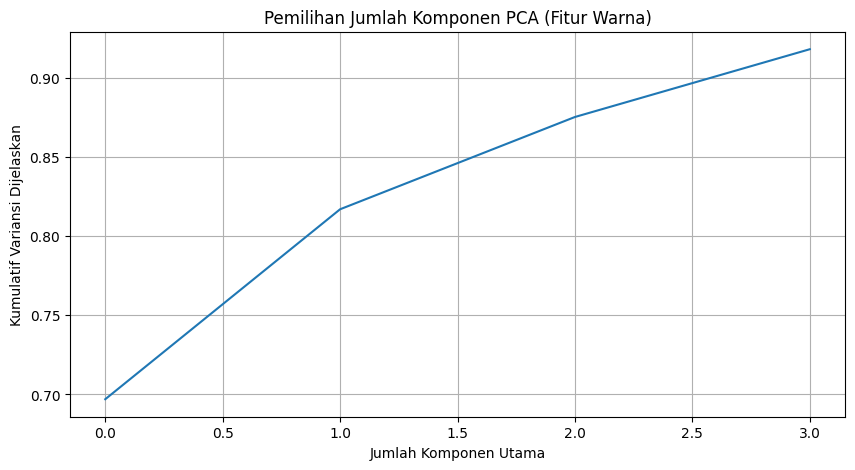

In [ ]:
# Inisialisasi PCA dengan target variansi 90%
pca_color = PCA(n_components=0.90)

# Terapkan PCA pada data latih
X_train_pca_color = pca_color.fit_transform(X_train_color)

# Terapkan Transform pada data uji
X_test_pca_color = pca_color.transform(X_test_color)

print("\n--- Hasil PCA (Fitur Warna 90%) ---")
print(f"Jumlah Fitur Asli: {X_train_color.shape[1]}")
print(f"Jumlah Komponen Utama yang Dipilih: {pca_color.n_components_}")
print(f"Total Variansi yang Dipertahankan: {pca_color.explained_variance_ratio_.sum() * 100:.2f}%")
print(f"Bentuk Data Latih (PCA Features): {X_train_pca_color.shape}")
print(f"Bentuk Data Uji (PCA Features): {X_test_pca_color.shape}")

# Visualisasi Explained Variance Ratio
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca_color.explained_variance_ratio_))
plt.xlabel('Jumlah Komponen Utama')
plt.ylabel('Kumulatif Variansi Dijelaskan')
plt.title('Pemilihan Jumlah Komponen PCA (Fitur Warna)')
plt.grid(True)
plt.show()

In [ ]:
# Buat DataFrame berisi informasi variansi tiap komponen
pca_variance_df = pd.DataFrame({
    "Komponen": [f"PC{i+1}" for i in range(len(pca_color.explained_variance_ratio_))],
    "Variansi (%)": pca_color.explained_variance_ratio_ * 100,
    "Kumulatif Variansi (%)": np.cumsum(pca_color.explained_variance_ratio_) * 100
})

# Tampilkan tabel
print("\n--- Detail Variansi Tiap Komponen PCA ---")
display(pca_variance_df.round(2))


--- Detail Variansi Tiap Komponen PCA ---


,Komponen,Variansi (%),Kumulatif Variansi (%)
0,PC1,69.699997,69.699997
1,PC2,11.990000,81.690002
2,PC3,5.830000,87.519997
3,PC4,4.280000,91.800003


In [ ]:
# Uji Nilai K yang Berbeda
k_values = [3, 5, 7, 9, 11]
best_k_color = 0
best_accuracy_color = 0

print("\n--- Pengujian Nilai K untuk KNN (Fitur Warna) ---")
for k in k_values:
    knn_color = KNeighborsClassifier(n_neighbors=k)
    knn_color.fit(X_train_pca_color, y_train)
    y_pred_color = knn_color.predict(X_test_pca_color)
    accuracy_color = accuracy_score(y_test, y_pred_color)

    print(f"K={k}: Akurasi = {accuracy_color:.4f}")

    if accuracy_color > best_accuracy_color:
        best_accuracy_color = accuracy_color
        best_k_color = k

print(f"\nNilai K Terbaik yang Ditemukan: {best_k_color} dengan Akurasi {best_accuracy_color:.4f}")


--- Pengujian Nilai K untuk KNN (Fitur Warna) ---
K=3: Akurasi = 0.5333
K=5: Akurasi = 0.6667
K=7: Akurasi = 0.7333
K=9: Akurasi = 0.8000
K=11: Akurasi = 0.6667

Nilai K Terbaik yang Ditemukan: 9 dengan Akurasi 0.8000



--- Hasil Evaluasi Akhir (Fitur Warna) ---
Akurasi Model (K=9): 80.00%

Laporan Klasifikasi:
              precision    recall  f1-score   support

        Cool       0.80      1.00      0.89         4
     Neutral       0.83      0.83      0.83         6
        Warm       0.75      0.60      0.67         5

    accuracy                           0.80        15
   macro avg       0.79      0.81      0.80        15
weighted avg       0.80      0.80      0.79        15

Confusion matrix, without normalization


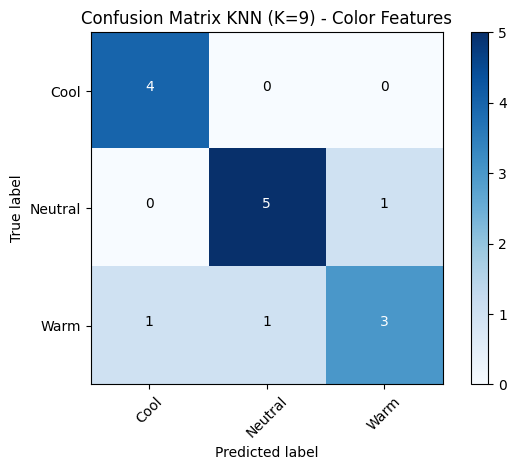

In [ ]:
# Model Akhir dengan K Terbaik
final_knn_color = KNeighborsClassifier(n_neighbors=best_k_color)
final_knn_color.fit(X_train_pca_color, y_train)
y_pred_final_color = final_knn_color.predict(X_test_pca_color)

# 1. Akurasi
final_accuracy_color = accuracy_score(y_test, y_pred_final_color)
print("\n--- Hasil Evaluasi Akhir (Fitur Warna) ---")
print(f"Akurasi Model (K={best_k_color}): {final_accuracy_color * 100:.2f}%")

# 2. Confusion Matrix
conf_matrix_color = confusion_matrix(y_test, y_pred_final_color)
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred_final_color, target_names=CLASS_LABELS))

# Fungsi plot_confusion_matrix dari kode lama Anda (asumsi sudah di-run)
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Fungsi untuk mencetak dan memplot confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Panggil fungsi plot
plot_confusion_matrix(conf_matrix_color, classes=CLASS_LABELS, title=f'Confusion Matrix KNN (K={best_k_color}) - Color Features')